<a href="https://colab.research.google.com/github/POPE001/Alzheimer-Risk-Assessment/blob/main/Risk_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FULL PROJECT ON THE TIMESERIES CLASSIFICATION, TO PREDICT ON THE ONSET OF ALZHEIMER'S DISEASES USING CNVOLUTIONAL NEURAL NETWORK

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout,LSTM, Dropout, Reshape
import os
from google.colab import drive
import numpy as np
from tensorflow.keras.utils import plot_model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import zscore
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA



In [ ]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

drive_path = '/content/drive/MyDrive'
files = os.listdir(drive_path)

### Data Collection

In [ ]:
#load the dataset
df = pd.read_csv('/content/drive/MyDrive/risk assessment/investigator_nacc61.csv')


<ipython-input-4-1a8c148fa3c5>:2: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/risk assessment/investigator_nacc61.csv')


#Data Preprocessing

In [ ]:
# check the dimension of the data
df.shape

(177112, 1024)

In [ ]:
df.head()

,NACCID,NACCADC,PACKET,FORMVER,VISITMO,VISITDAY,VISITYR,NACCVNUM,NACCAVST,NACCNVST,...,NPATGAM1,NPATGAM2,NPATGAM3,NPATGAM4,NPATGAM5,NPATGFRN,NPATGFR1,NPATGFR2,NPATGFR3,NPATGFR4
0,NACC002909,186,I,3.0,12,28,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,NACC004352,186,I,3.0,10,5,2021,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,NACC008514,186,I,3.0,11,15,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,NACC013667,186,I,3.0,3,29,2022,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,NACC020208,186,I,3.0,6,9,2020,1,1,1,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [ ]:
#checking the data types of the columns present in the dataset
df.dtypes

NACCID       object
NACCADC       int64
PACKET       object
FORMVER     float64
VISITMO       int64
             ...   
NPATGFRN      int64
NPATGFR1      int64
NPATGFR2      int64
NPATGFR3      int64
NPATGFR4      int64
Length: 1024, dtype: object

In [ ]:
#checking for missing values
df.isnull().sum()

NACCID      0
NACCADC     0
PACKET      0
FORMVER     0
VISITMO     0
           ..
NPATGFRN    0
NPATGFR1    0
NPATGFR2    0
NPATGFR3    0
NPATGFR4    0
Length: 1024, dtype: int64

In [ ]:
df['year'] = df['VISITYR'].astype(str) # assigning new variables
df['month'] = df['VISITMO'].astype(str)
df['day'] = df['VISITDAY'].astype(str)


In [ ]:
# Combine year, month, and day columns to create a 'DATE' column
df['DATE'] = pd.to_datetime(df['year'] + '-' + df['month'] + '-' + df['day'], format='%Y-%m-%d')


In [ ]:
# Filter data from the last 10 years
current_year = 2023  #current year
data_last_10_years = df[df['DATE'].dt.year >= current_year - 10]


In [ ]:
# Fill missing values with column means
numeric_columns = ['NACCAGE', 'SEX', 'RACE', 'HISPANIC', 'MARISTAT', 'INDEPEND', 'RESIDENC']
data_last_10_years_filled = data_last_10_years.copy()
data_last_10_years_filled[numeric_columns] = data_last_10_years_filled[numeric_columns].fillna(data_last_10_years_filled[numeric_columns].mean())


In [ ]:
#to avoid warnings
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
#printing the list of columns present
print(data_last_10_years.columns.tolist())

['NACCID', 'NACCADC', 'PACKET', 'FORMVER', 'VISITMO', 'VISITDAY', 'VISITYR', 'NACCVNUM', 'NACCAVST', 'NACCNVST', 'NACCDAYS', 'NACCFDYS', 'NACCCORE', 'NACCREAS', 'NACCREFR', 'BIRTHMO', 'BIRTHYR', 'SEX', 'HISPANIC', 'HISPOR', 'HISPORX', 'RACE', 'RACEX', 'RACESEC', 'RACESECX', 'RACETER', 'RACETERX', 'PRIMLANG', 'PRIMLANX', 'EDUC', 'MARISTAT', 'NACCLIVS', 'INDEPEND', 'RESIDENC', 'HANDED', 'INBIRMO', 'INBIRYR', 'INSEX', 'NEWINF', 'INHISP', 'INHISPOR', 'INHISPOX', 'NACCNINR', 'INRACE', 'INRACEX', 'INRASEC', 'INRASECX', 'INRATER', 'INRATERX', 'INEDUC', 'INRELTO', 'INRELTOX', 'INKNOWN', 'INLIVWTH', 'INVISITS', 'INCALLS', 'INRELY', 'NACCFAM', 'NACCMOM', 'NACCDAD', 'NACCAM', 'NACCAMX', 'NACCAMS', 'NACCAMSX', 'NACCFM', 'NACCFMX', 'NACCFMS', 'NACCFMSX', 'NACCOM', 'NACCOMX', 'NACCOMS', 'NACCOMSX', 'NACCFADM', 'NACCFFTD', 'ANYMEDS', 'DRUG1', 'DRUG2', 'DRUG3', 'DRUG4', 'DRUG5', 'DRUG6', 'DRUG7', 'DRUG8', 'DRUG9', 'DRUG10', 'DRUG11', 'DRUG12', 'DRUG13', 'DRUG14', 'DRUG15', 'DRUG16', 'DRUG17', 'DRUG18'

# Data Preparation


In [ ]:
demographic_features = ['NACCAGE', 'SEX', 'RACE', 'HISPANIC', 'MARISTAT', 'INDEPEND', 'RESIDENC']
target_variables = ['NACCALZD', 'NACCALZP']
selected_features = demographic_features + target_variables
selected_data = df[selected_features]


In [ ]:
# Display the features in a table
print(selected_data.head())


   NACCAGE  SEX  RACE  HISPANIC  MARISTAT  INDEPEND  RESIDENC  NACCALZD  \
0       70    1     1         0         1         1         1         0   
1       63    2     1         1         1         2         1         1   
2       86    1     1         0         1         1         1         1   
3       76    1     1         0         1         2         1         1   
4       69    1     1         1         1         2         1         1   

   NACCALZP  
0         7  
1         1  
2         2  
3         1  
4         1  


In [ ]:
# Calculate mean and standard deviation of age for males and females
mean_age_male = data_last_10_years_filled[data_last_10_years_filled['SEX'] == 1]['NACCAGE'].mean()
std_age_male = data_last_10_years_filled[data_last_10_years_filled['SEX'] == 1]['NACCAGE'].std()
mean_age_female = data_last_10_years_filled[data_last_10_years_filled['SEX'] == 2]['NACCAGE'].mean()
std_age_female = data_last_10_years_filled[data_last_10_years_filled['SEX'] == 2]['NACCAGE'].std()


print("Male:")
print(f"Mean Age: {mean_age_male:.2f}")
print(f"Standard Deviation Age: {std_age_male:.2f}")
print("\nFemale:")
print(f"Mean Age: {mean_age_female:.2f}")
print(f"Standard Deviation Age: {std_age_female:.2f}")


Male:
Mean Age: 74.33
Standard Deviation Age: 10.24

Female:
Mean Age: 74.39
Standard Deviation Age: 10.23


In [ ]:
# Calculate total population for males and females
total_population_male = data_last_10_years[data_last_10_years['SEX'] == 1]['SEX'].count()
total_population_female = data_last_10_years[data_last_10_years['SEX'] == 2]['SEX'].count()

print("Total Population for Last 10 Years:")
print(f"Male: {total_population_male}")
print(f"Female: {total_population_female}")



Total Population for Last 10 Years:
Male: 40699
Female: 56826


# Data Visualization


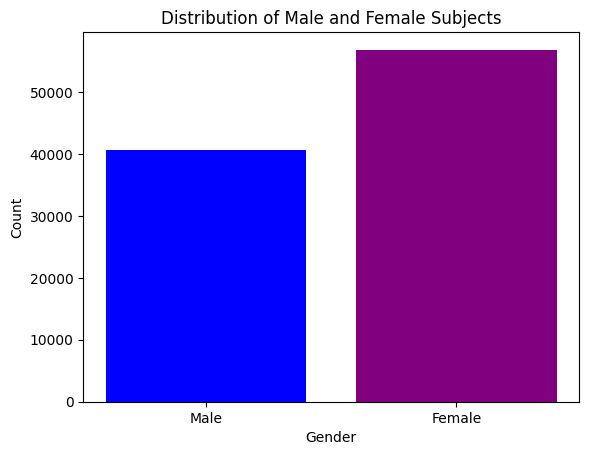

In [ ]:
import matplotlib.pyplot as plt

# Create a bar graph to visualize male vs. female distribution
genders = ['Male', 'Female']
counts = [total_population_male, total_population_female]

colors = ['blue', 'purple']  # Define colors for male and female
plt.bar(genders, counts, color=colors)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Male and Female Subjects')
plt.show()


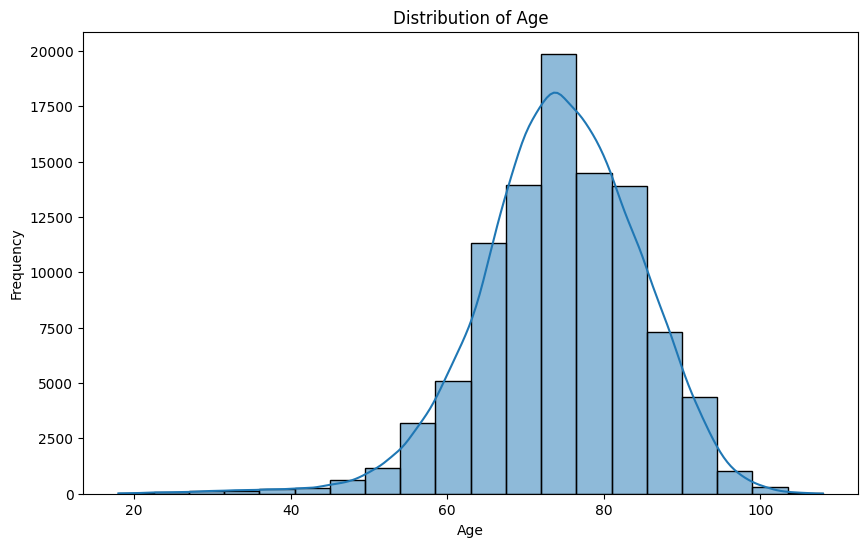

In [ ]:
import seaborn as sns
# Plot distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(data_last_10_years_filled, x='NACCAGE', bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()


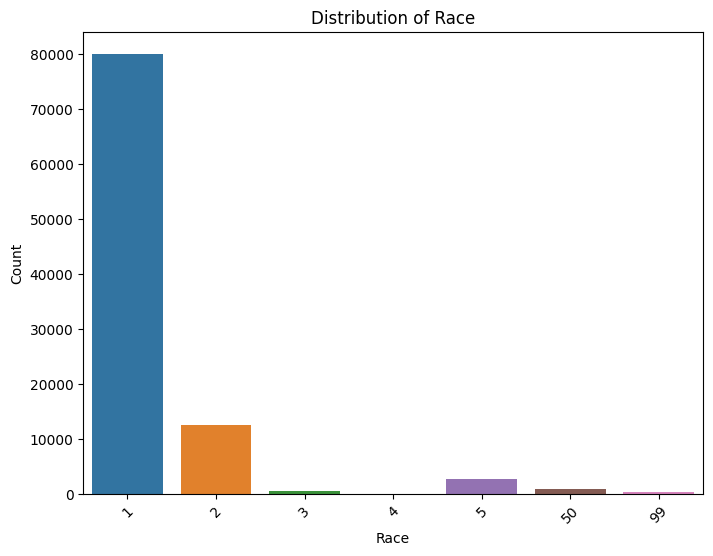

In [ ]:
# Plot distribution of race
plt.figure(figsize=(8, 6))
sns.countplot(data=data_last_10_years_filled, x='RACE')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Race')
plt.xticks(rotation=45)
plt.show()


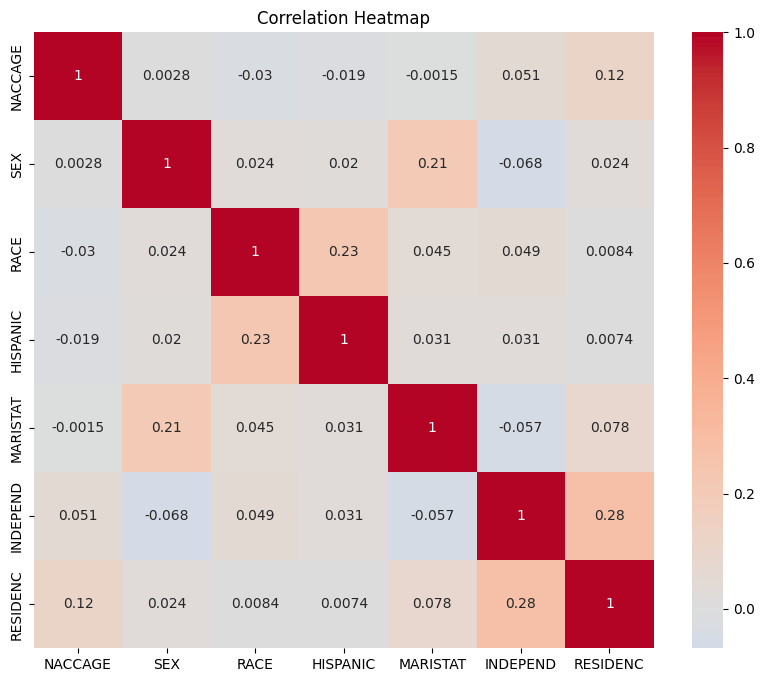

In [ ]:
# Calculate correlation matrix
correlation_matrix = data_last_10_years_filled[demographic_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


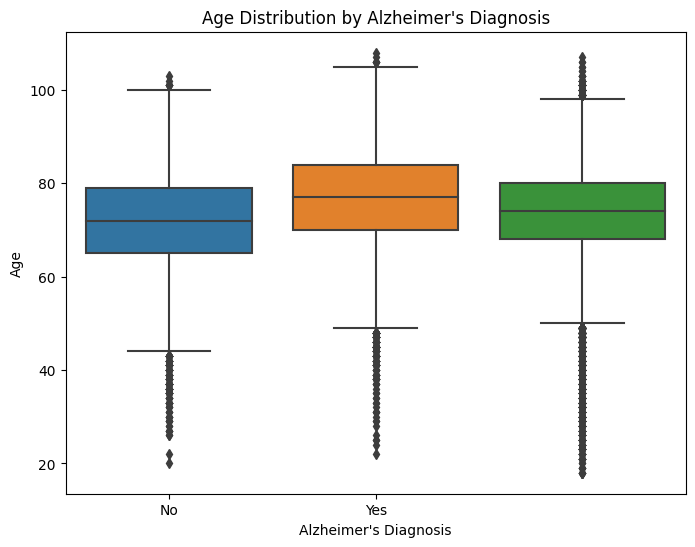

In [ ]:
# box plot of age by Alzheimer's diagnosis
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_last_10_years_filled, x='NACCALZD', y='NACCAGE')
plt.xlabel('Alzheimer\'s Diagnosis')
plt.ylabel('Age')
plt.title('Age Distribution by Alzheimer\'s Diagnosis')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


1/1 [==============================] - 0s 171ms/step


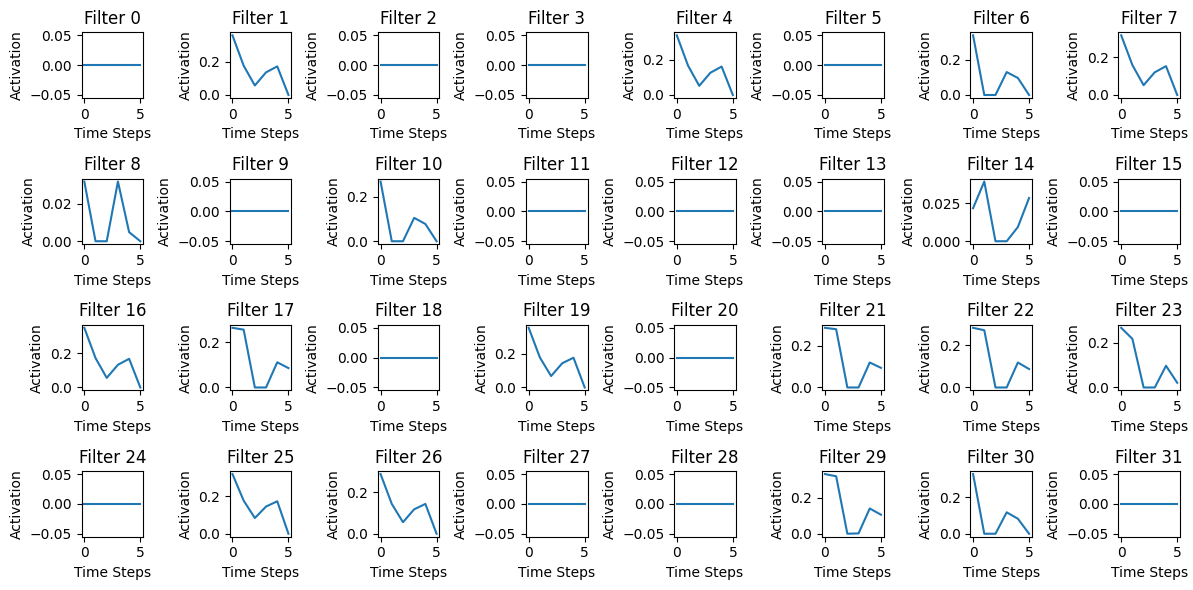

In [ ]:
from tensorflow.keras.models import Model

# Create a model that outputs the activations of the convolutional layers
activation_model = Model(inputs=model.input, outputs=model.layers[0].output)

# Select a random sample from the test data
sample_index = np.random.randint(0, X_test.shape[0])
sample = X_test[sample_index]

# Get activations for the sample
activations = activation_model.predict(sample.reshape(1, *sample.shape))

# Plot activations as line plots
plt.figure(figsize=(12, 6))
for i in range(32):  # Number of filters in the first convolutional layer
    plt.subplot(4, 8, i + 1)
    plt.plot(activations[0, :, i])
    plt.title(f"Filter {i}")
    plt.xlabel("Time Steps")
    plt.ylabel("Activation")
plt.tight_layout()
plt.show()


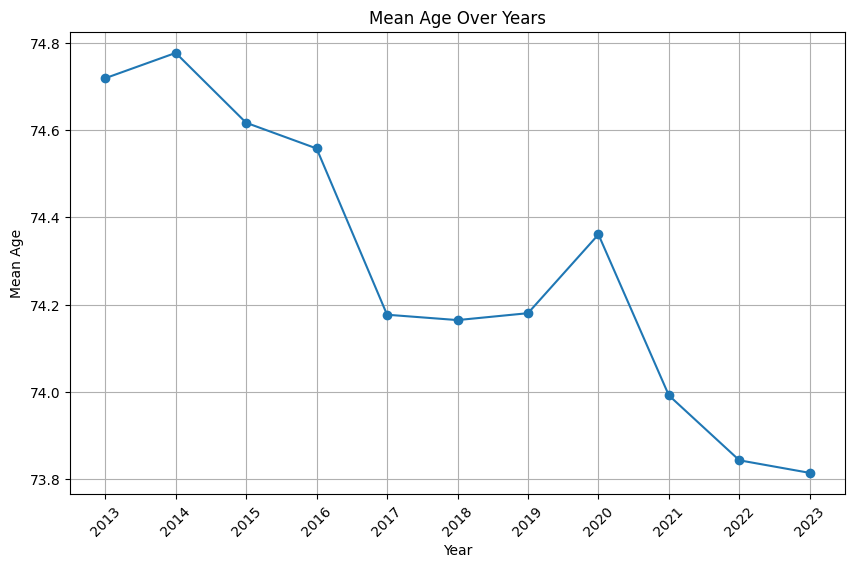

In [ ]:
# Group data by year and calculate mean age
mean_age_by_year = data_last_10_years_filled.groupby('year')['NACCAGE'].mean()

# Plot mean age over years
plt.figure(figsize=(10, 6))
plt.plot(mean_age_by_year.index, mean_age_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Mean Age')
plt.title('Mean Age Over Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Create day of the week feature
data_last_10_years_filled['day_of_week'] = data_last_10_years_filled['DATE'].dt.dayofweek



In [ ]:
# Create interaction feature
age_sex_interaction = data_last_10_years_filled['NACCAGE'] * data_last_10_years_filled['SEX']
data_last_10_years_filled = pd.concat([data_last_10_years_filled, age_sex_interaction], axis=1)
data_last_10_years_filled.rename(columns={0: 'age_sex_interaction'}, inplace=True)


In [ ]:
# Encode categorical features
categorical_features = ['RACE', 'MARISTAT']
data_encoded = pd.get_dummies(data_last_10_years_filled, columns=categorical_features, drop_first=True)


In [ ]:
# Use selected features for training
#selected_features = ['NACCAGE', 'SEX', 'INDEPEND', 'day_of_week', 'age_sex_interaction', 'RACE_2', 'RACE_3', 'MARISTAT_2', 'MARISTAT_3']
#X = data_encoded[selected_features].values


In [ ]:
X = data_last_10_years[demographic_features].values


In [ ]:
y = data_last_10_years[target_variables].values


# Data Preprocessing


In [ ]:
# Data Preprocessing
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Data Representation
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [ ]:
from sklearn.utils.class_weight import compute_class_weight
# Convert y_train to 1D array
y_train_flat = y_train.flatten()
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_flat), y=y_train_flat)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Outlier Detection and Handling (Using Z-Score)
z_scores = zscore(X_scaled)
filtered_entries = (z_scores < 3).all(axis=1)
X_filtered = X_scaled[filtered_entries]
y_filtered = y[filtered_entries]


In [ ]:
# Feature Engineering (Adding Polynomial Features)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_scaled)


In [ ]:
# Time-Series Specific Preprocessing (Rolling Mean)
window_size = 3
rolling_mean = pd.DataFrame(X_scaled).rolling(window=window_size).mean()
X_with_rolling_mean = np.concatenate([X_scaled, rolling_mean], axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Perform a new train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create a RandomForestClassifier estimator
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the RFE selector
selector = RFE(estimator, n_features_to_select=5)

# Fit and transform the data using the selector
X_selected = selector.fit_transform(X_train, y_train)


In [ ]:
# Data Augmentation (Adding Gaussian Noise)
noise_factor = 0.01
X_augmented = X_scaled + noise_factor * np.random.randn(*X_scaled.shape)


In [ ]:
# Dimensionality Reduction (PCA)
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)


In [ ]:
# Temporal Aggregations (Monthly Mean)
data_last_10_years_filled['month'] = data_last_10_years_filled['DATE'].dt.month
numeric_columns = data_last_10_years_filled.select_dtypes(include=np.number).columns
monthly_means = data_last_10_years_filled.groupby('month')[numeric_columns].mean()
X_monthly_mean = monthly_means[demographic_features].values


In [ ]:
# Handling Seasonality and Trends (Differencing)
X_diff = np.diff(X_scaled, axis=0)


In [ ]:
# Define input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = 9
min_class_index = np.min(y_train)
max_class_index = np.max(y_train)


In [ ]:
print(input_shape)

(7,)


In [ ]:
print("Min Class Index:", min_class_index)
print("Max Class Index:", max_class_index)


Min Class Index: 0
Max Class Index: 8


In [ ]:
# Define your sequence length (number of time steps)
sequence_length = 2
num_classes = 9

# One-hot encode target labels with sequence length
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)


In [ ]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.2 MB/s eta 0:00:00


# Defining and training the convolutional neural network model


In [ ]:
from tensorflow.keras.layers import BatchNormalization


# Define a model with L2 regularization and dropout
model = tf.keras.models.Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(input_shape[0], 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization layer
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(64, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(sequence_length * num_classes, activation='softmax'),  # Output sequence
    Reshape((sequence_length, num_classes))  # sequence length
])

# Model Training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[early_stop])

# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
2134/2134 [==============================] - 11s 4ms/step - loss: 1.0269 - accuracy: 0.6682 - val_loss: 0.8625 - val_accuracy: 0.6885
Epoch 2/10
2134/2134 [==============================] - 10s 5ms/step - loss: 0.8671 - accuracy: 0.6906 - val_loss: 0.8510 - val_accuracy: 0.7037
Epoch 3/10
2134/2134 [==============================] - 10s 5ms/step - loss: 0.8608 - accuracy: 0.6937 - val_loss: 0.8360 - val_accuracy: 0.6957
Epoch 4/10
2134/2134 [==============================] - 9s 4ms/step - loss: 0.8558 - accuracy: 0.6951 - val_loss: 0.8384 - val_accuracy: 0.7023
Epoch 5/10
2134/2134 [==============================] - 9s 4ms/step - loss: 0.8516 - accuracy: 0.6955 - val_loss: 0.8327 - val_accuracy: 0.7069
Epoch 6/10
2134/2134 [==============================] - 10s 5ms/step - loss: 0.8490 - accuracy: 0.6964 - val_loss: 0.8393 - val_accuracy: 0.6945
Epoch 7/10
2134/2134 [==============================] - 8s 4ms/step - loss: 0.8486 - accuracy: 0.6970 - val_loss: 0.8340 - val_accur

In [ ]:
from tensorflow.keras.utils import to_categorical

# Define your sequence length (number of time steps)
sequence_length = 2
num_classes = 9

# Custom loss function with class weights
def weighted_categorical_crossentropy(class_weights):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        # Calculate cross-entropy loss for each class and weight it
        weighted_losses = tf.multiply(
            y_true * tf.math.log(y_pred + 1e-8),
            class_weights
        )
        return -tf.reduce_mean(tf.reduce_sum(weighted_losses, axis=-1))

    return loss



# One-hot encode target labels with sequence length
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define a model with L2 regularization and dropout
model = Sequential([
    Conv1D(32, kernel_size=2, activation='relu', input_shape=(input_shape[0], 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Add BatchNormalization layer
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(32, kernel_size=2, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(sequence_length * num_classes, activation='softmax'),  # Output sequence
    Reshape((sequence_length, num_classes))  # sequence length
])

# Model Training with class weights
# Compile the model with categorical cross-entropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model with class weights
model.fit(X_train, y_train_encoded, epochs=10, batch_size=16, validation_data=(X_val, y_val_encoded), callbacks=[early_stop])

# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/10
4267/4267 [==============================] - 26s 6ms/step - loss: 0.9842 - accuracy: 0.6664 - val_loss: 0.8523 - val_accuracy: 0.7040
Epoch 2/10
4267/4267 [==============================] - 17s 4ms/step - loss: 0.8699 - accuracy: 0.6898 - val_loss: 0.8426 - val_accuracy: 0.7022
Epoch 3/10
4267/4267 [==============================] - 16s 4ms/step - loss: 0.8593 - accuracy: 0.6927 - val_loss: 0.8390 - val_accuracy: 0.7025
Epoch 4/10
4267/4267 [==============================] - 16s 4ms/step - loss: 0.8577 - accuracy: 0.6923 - val_loss: 0.8324 - val_accuracy: 0.6953
Epoch 5/10
4267/4267 [==============================] - 15s 4ms/step - loss: 0.8553 - accuracy: 0.6931 - val_loss: 0.8318 - val_accuracy: 0.7048
Epoch 6/10
4267/4267 [==============================] - 15s 4ms/step - loss: 0.8542 - accuracy: 0.6929 - val_loss: 0.8327 - val_accuracy: 0.7052
Epoch 7/10
4267/4267 [==============================] - 15s 4ms/step - loss: 0.8523 - accuracy: 0.6927 - val_loss: 0.8382 - val_ac

#Evaluation

In [ ]:
from sklearn.metrics import recall_score, f1_score

# Calculate metrics
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=2)
y_test_labels = np.argmax(y_test_encoded, axis=2)

recall = recall_score(y_test_labels.flatten(), y_pred_labels.flatten(), average='weighted')
f1 = f1_score(y_test_labels.flatten(), y_pred_labels.flatten(), average='weighted')

print("Weighted Recall:", recall)
print("Weighted F1-score:", f1)


458/458 [==============================] - 1s 3ms/step
Weighted Recall: 0.6957755143892269
Weighted F1-score: 0.6321889094363812


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Update num_classes to match the actual number of classes in your model
num_classes = 6

# Predict on the test data
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=2)
y_test_labels = np.argmax(y_test_encoded, axis=2)

# Get class names
class_names = [f"Class {i}" for i in range(num_classes)]

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels.flatten(), y_pred_labels.flatten()))

print("\nClassification Report:")
print(classification_report(y_test_labels.flatten(), y_pred_labels.flatten(), target_names=class_names, zero_division=1))


458/458 [==============================] - 1s 1ms/step
Confusion Matrix:
[[    0   904     0     0     0  1215]
 [    0  6076     0     0     0  3561]
 [    0   165     0     0     0    78]
 [    0     2     0     0     0     4]
 [    0   902     0     0     0  1217]
 [    0   853     0     0     0 14281]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.00      0.00      2119
     Class 1       0.68      0.63      0.66      9637
     Class 2       1.00      0.00      0.00       243
     Class 3       1.00      0.00      0.00         6
     Class 4       1.00      0.00      0.00      2119
     Class 5       0.70      0.94      0.80     15134

    accuracy                           0.70     29258
   macro avg       0.90      0.26      0.24     29258
weighted avg       0.74      0.70      0.63     29258



In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

# Calculate sensitivity and specificity
def calculate_sensitivity_specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

# Calculate AUROC
def calculate_auroc(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    return roc_auc


#Confusion Matrix

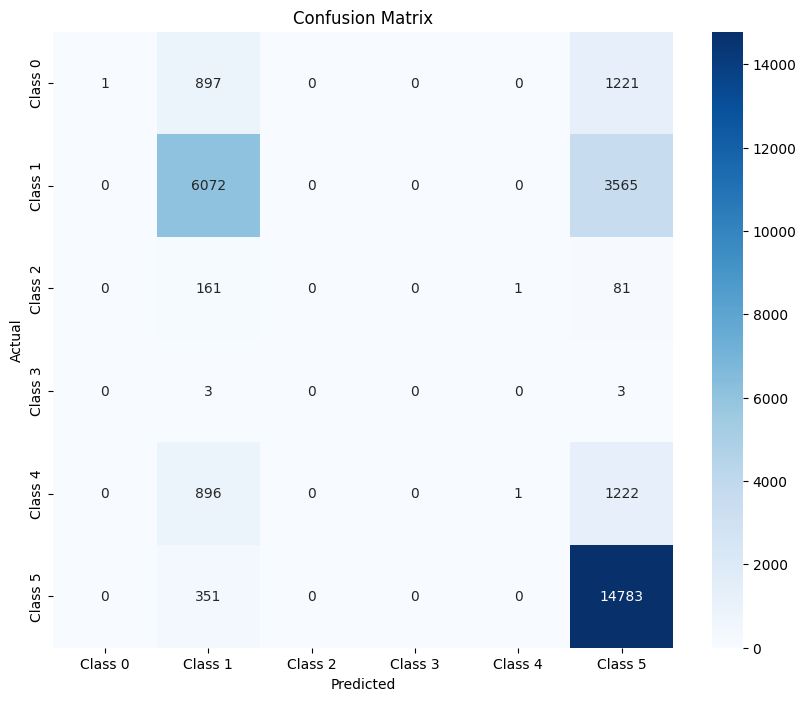

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_labels.flatten(), y_pred_labels.flatten())

# Create a list of class names
class_names = [f"Class {i}" for i in range(num_classes)]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#Model Evaluation Visualization

Epoch 1/10
4267/4267 [==============================] - 12s 3ms/step - loss: 0.8669 - accuracy: 0.6950 - val_loss: 0.8560 - val_accuracy: 0.7005
Epoch 2/10
4267/4267 [==============================] - 10s 2ms/step - loss: 0.8669 - accuracy: 0.6943 - val_loss: 0.8507 - val_accuracy: 0.7016
Epoch 3/10
4267/4267 [==============================] - 9s 2ms/step - loss: 0.8654 - accuracy: 0.6952 - val_loss: 0.8495 - val_accuracy: 0.7018
Epoch 4/10
4267/4267 [==============================] - 12s 3ms/step - loss: 0.8658 - accuracy: 0.6950 - val_loss: 0.8494 - val_accuracy: 0.7005
Epoch 5/10
4267/4267 [==============================] - 10s 2ms/step - loss: 0.8649 - accuracy: 0.6944 - val_loss: 0.8490 - val_accuracy: 0.6990
Epoch 6/10
4267/4267 [==============================] - 9s 2ms/step - loss: 0.8644 - accuracy: 0.6951 - val_loss: 0.8588 - val_accuracy: 0.7059
Epoch 7/10
4267/4267 [==============================] - 11s 3ms/step - loss: 0.8608 - accuracy: 0.6987 - val_loss: 0.8411 - val_accu

Text(0.5, 1.0, 'Training and Validation Loss')

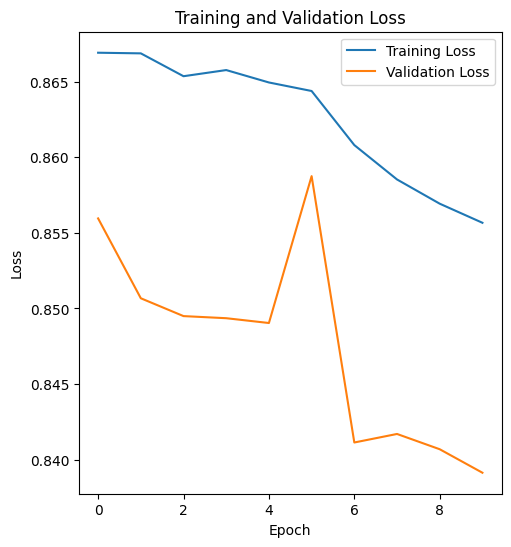

In [ ]:
import matplotlib.pyplot as plt

history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=16, validation_data=(X_val, y_val_encoded), callbacks=[early_stop])
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

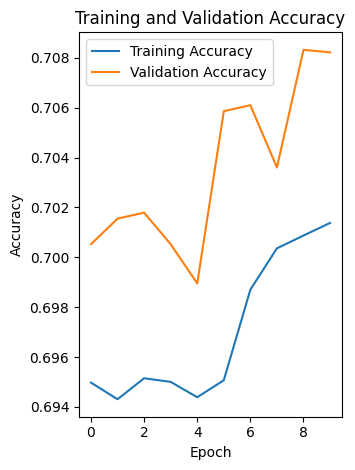

In [ ]:
# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

#Model Architecture

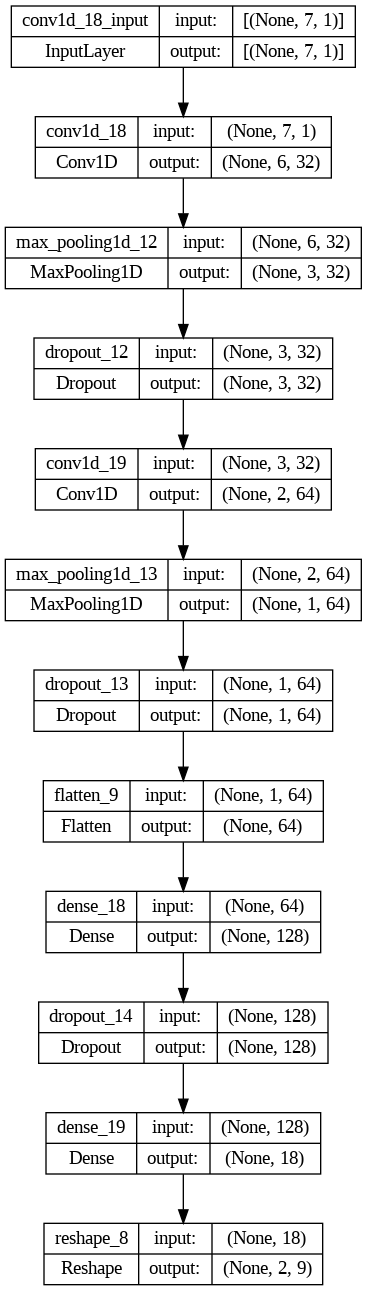

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (68267, 7)
Shape of X_val: (14629, 7, 1)
Shape of X_test: (14629, 7, 1)


In [ ]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_encoded_reshaped = y_train_encoded.reshape(-1, num_classes)
print("Reshaped shape of X_train_lstm:", X_train_lstm.shape)
print("Reshaped shape of y_train_encoded_reshaped:", y_train_encoded_reshaped.shape)


Reshaped shape of X_train_lstm: (68267, 7, 1)
Reshaped shape of y_train_encoded_reshaped: (136534, 9)


In [ ]:
print("Example X_train_lstm:")
print(X_train_lstm[0])  # Print the first example
print("Example y_train_encoded_reshaped:")
print(y_train_encoded_reshaped[0])  # Print the corresponding target label


Example X_train_lstm:
[[0.64444444]
 [0.        ]
 [0.5       ]
 [0.11111111]
 [0.        ]
 [0.        ]
 [0.        ]]
Example y_train_encoded_reshaped:
[1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode target labels with num_classes
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Reshape target labels
y_train_encoded_reshaped = y_train_encoded.reshape(-1, num_classes)
y_val_encoded_reshaped = y_val_encoded.reshape(-1, num_classes)
y_test_encoded_reshaped = y_test_encoded.reshape(-1, num_classes)


In [ ]:
# Load and preprocess your data
X_train, X_val, X_test, y_train, y_val, y_test = data_last_10_years

# Reshape input data
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encode target labels with num_classes
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_val_encoded = to_categorical(y_val, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Reshape target labels
# Reshape target labels
y_train_encoded_reshaped = y_train_encoded.reshape(-1, num_classes)
y_val_encoded_reshaped = y_val_encoded.reshape(-1, num_classes)
y_test_encoded_reshaped = y_test_encoded.reshape(-1, num_classes)

# Ensure the shapes match
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of y_train_encoded_reshaped:", y_train_encoded_reshaped.shape)
print("Shape of X_val_lstm:", X_val_lstm.shape)
print("Shape of y_val_encoded:", y_val_encoded_reshaped.shape)
print("Shape of X_test_lstm:", X_test_lstm.shape)
print("Shape of y_test_encoded:", y_test_encoded_reshaped.shape)


Shape of X_train_lstm: (68267, 7, 1)
Shape of y_train_encoded_reshaped: (136534, 9)
Shape of X_val_lstm: (14629, 7, 1)
Shape of y_val_encoded: (29258, 9)
Shape of X_test_lstm: (14629, 7, 1)
Shape of y_test_encoded: (29258, 9)


In [ ]:
# Print original shapes
print("Original shape of X_train:", X_train.shape)
print("Original shape of y_train_encoded:", y_train_encoded.shape)

# Reshape the input data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_lstm = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Reshape the target labels to have shape (samples, num_classes)
y_train_encoded_reshaped = y_train_encoded.reshape(-1, num_classes)
y_val_encoded_reshaped = y_val_encoded.reshape(-1, num_classes)
y_test_encoded_reshaped = y_test_encoded.reshape(-1, num_classes)

# Print reshaped shapes
print("Reshaped shape of X_train_lstm:", X_train_lstm.shape)
print("Reshaped shape of y_train_encoded_reshaped:", y_train_encoded_reshaped.shape)

# Print a few examples to verify
print("Example X_train_lstm:")
print(X_train_lstm[0])  # Print the first sample
print("Example y_train_encoded_reshaped:")
print(y_train_encoded_reshaped[0])  # Print the encoded label of the first sample


Original shape of X_train: (68267, 7)
Original shape of y_train_encoded: (136534, 9)
Reshaped shape of X_train_lstm: (68267, 7, 1)
Reshaped shape of y_train_encoded_reshaped: (136534, 9)
Example X_train_lstm:
[[0.64444444]
 [0.        ]
 [0.5       ]
 [0.11111111]
 [0.        ]
 [0.        ]
 [0.        ]]
Example y_train_encoded_reshaped:
[1. 0. 0. 0. 0. 0. 0. 0. 0.]
